# Project: Adult Dataset

- **Project Name:** Adult Classification Project
- **Project Type:** Binary-class Classification
- **Author:** Dr. Saad Laouadi

### Project Overview:
This project leverages the famous **Adult Dataset**, also known as the **Census Income Dataset**, for a **binary-class classification** problem. The objective is to predict whether a person earns more than $50,000 a year based on various demographic features.

The primary focus of this notebook is **data preprocessing**, which includes handling missing values, encoding categorical variables, and feature scaling to prepare the data for machine learning algorithms.

### Dataset Details:
- **Source**: The Adult Dataset is derived from the 1994 U.S. Census database.
- **Classes**: Binary classification task - the target is to predict income (<=50K or >50K).
- **Number of Samples**: 48,842
- **Number of Features**: 14 features (including age, education, occupation, race, etc.)

### Key Features:
- **Preprocessing Tasks**:
  - Handle missing or incomplete data
  - Encode categorical variables
  - Feature scaling (e.g., Standardization, Normalization)

### Objectives:
1. **Preprocess the dataset**:
   - Handle missing values
   - Convert categorical data into numeric form using encoding techniques
   - Scale/normalize features for optimal performance in future machine learning models
2. **Prepare the dataset** for modeling and evaluation in the next notebook.

---

**Copyright © Dr. Saad Laouadi**  
**All Rights Reserved** 🛡️

In [1]:
# Import necessary modules
import os
import re
import requests
import json 
from io import StringIO
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Configuration Variables
PRINT_INFO = True

with open('config.json', 'r') as file:
    config = json.load(file)

train_data_url = config['TRAIN_DATA']
test_data_url = config['TEST_DATA']
info_data_url = config['INFO_DATA']

processed_train_data = config['PROCESSED_TRAIN_DATA']
model_save_path = config['MODEL_SAVE_PATH']
metrics_save_path = config['METRICS_SAVE_PATH']
random_seed = config['RANDOM_SEED']

if PRINT_INFO:
    print("Train Data URL:", train_data_url)
    print("Test Data URL:", test_data_url)
    print("Info Data URL:", info_data_url)
    
    print("Processed Train Data Path:", processed_train_data)
    print("Model Save Path:", model_save_path)
    print("Metrics Save Path:", metrics_save_path)
    print("Random Seed:", random_seed)


%load_ext autoreload
%autoreload 2

from utils import *

%load_ext watermark
%watermark -iv -v  

Train Data URL: https://raw.githubusercontent.com/qcversity/ml-datasets/refs/heads/main/data/adult.train
Test Data URL: https://raw.githubusercontent.com/qcversity/ml-datasets/refs/heads/main/data/adult.test
Info Data URL: https://raw.githubusercontent.com/qcversity/ml-datasets/refs/heads/main/data/adult.info.txt
Processed Train Data Path: data/processed_train.csv
Model Save Path: models/adult_model.pkl
Metrics Save Path: metrics/adult_model_metrics.json
Random Seed: 0
Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

matplotlib: 3.9.2
re        : 2.2.1
requests  : 2.32.3
numpy     : 1.26.4
json      : 2.0.9
pandas    : 2.2.2
seaborn   : 0.13.2



### Check the Data information

In [2]:
# Fetch the content of data info from the info_data_url 
response = requests.get(info_data_url)

# Print the content of the text file
print(response.text)

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [3]:
# Download the data if you need to 
# !wget https://raw.githubusercontent.com/qcversity/ml-datasets/refs/heads/main/data/adult.info.txt

### Extracting Feature Names

We will retrieve the names of the features from the provided data information file. This step ensures that we have a clear understanding of the dataset’s structure and feature descriptions before proceeding with analysis.

In [4]:
# Check the file with a text editor locally or online to get the following information

START_LINE = 94
END_LINE = None 
PATTERN = r"([a-zA-Z0-9\-]+):" 

# This function is user defined from the utils module
feature_names = extract_feature_names(info_data_url,
                                      start_line=START_LINE,
                                      end_line=END_LINE,
                                      pattern=PATTERN
                                     )

print("*"*72)
print(f"The extracted feature names:\n{feature_names}")
print(f"The number of features: {len(feature_names)}")
print("*"*72)

# Add the target to the list of feature names
target = ['income']
col_names = feature_names + target
print(f"The column names are:\n{col_names}")
print("*"*72)

************************************************************************
The extracted feature names:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
The number of features: 14
************************************************************************
The column names are:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
************************************************************************


### Reading the data
We will use `pandas` to read the train and test data. 
In some occasions, we won't have access to a certain program such as a text editor, or maybe working form a computer without graphical user interface, so it is usefull to have a closer look how the data looks like. We defined a function to display the first few lines so we can have an idea which function we will be using from `pandas`.

In [5]:
# preview data 
preview_raw_data_from_url(train_data_url)

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K


The previous data is comma separated value (CSV) data. We can use the `read_csv()` function.

In [6]:
# Read the train data
adult_train = pd.read_csv(train_data_url, names= col_names)

In [7]:
# Start Exploring the data
banner("*", 72, title = "Adult Train Data")

print(adult_train.head())
banner("*", 72, title = "Data Shape")
print(f"The adult train data shape: {adult_train.shape}")
print("*" * 72)

************************************************************************
                            Adult Train Data                            
************************************************************************
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4

In [8]:
banner("*", 72, "Adult train data Information")
adult_train.info()
print("*"*72)

************************************************************************
                      Adult train data Information                      
************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-

In [9]:
# preview the test data
banner("*", 72, "Adult test data Preview")
preview_raw_data_from_url(test_data_url)

************************************************************************
                        Adult test data Preview                         
************************************************************************
|1x3 Cross validator
25, Private, 226802, 11th, 7, Never-married, Machine-op-inspct, Own-child, Black, Male, 0, 0, 40, United-States, <=50K.
38, Private, 89814, HS-grad, 9, Married-civ-spouse, Farming-fishing, Husband, White, Male, 0, 0, 50, United-States, <=50K.
28, Local-gov, 336951, Assoc-acdm, 12, Married-civ-spouse, Protective-serv, Husband, White, Male, 0, 0, 40, United-States, >50K.
44, Private, 160323, Some-college, 10, Married-civ-spouse, Machine-op-inspct, Husband, Black, Male, 7688, 0, 40, United-States, >50K.


In [10]:
# Read the test data
adult_test = pd.read_csv(test_data_url, 
                         names = col_names,
                         skiprows=1
                        )

In [11]:
banner("*", 72, title = "Adult Test Data")
print(adult_test.head())

banner("*", 72, title = "Adult Test Data Shape")
print(f"The test data shape: {adult_test.shape}")
print("*"*72)

************************************************************************
                            Adult Test Data                             
************************************************************************
   age   workclass  fnlwgt      education  education-num       marital-status  \
0   25     Private  226802           11th              7        Never-married   
1   38     Private   89814        HS-grad              9   Married-civ-spouse   
2   28   Local-gov  336951     Assoc-acdm             12   Married-civ-spouse   
3   44     Private  160323   Some-college             10   Married-civ-spouse   
4   18           ?  103497   Some-college             10        Never-married   

           occupation relationship    race      sex  capital-gain  \
0   Machine-op-inspct    Own-child   Black     Male             0   
1     Farming-fishing      Husband   White     Male             0   
2     Protective-serv      Husband   White     Male             0   
3   Machine-op-ins

In [12]:
banner("*", 72, "Adult testdata Information")
adult_test.info()
print("*"*72)

************************************************************************
                       Adult testdata Information                       
************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-

## Data Cleaning
In this section, we will take a systematic approach to explore and understand the data. We will dive deeper to uncover patterns, identify inconsistencies, and flag potential issues that need to be addressed.

### Columns for Removal `Final Weight`

According to the metadata, the `fnlwgt` (final weight) column represents the proportion of the population with the same set of characteristics. Each row in the original dataset was de-duplicated, and the `fnlwgt` column indicates the number of records that share identical feature values. Since this column does not enhance the model’s predictive power, it can be excluded from the model training process.

for more information about this feature, [check here](references.md)

In [13]:
# Remove the final weight variable from both dataset
adult_train = adult_train.drop(columns=['fnlwgt'])
adult_test = adult_test.drop(columns=['fnlwgt'])

In [14]:
banner("*", 72, "Shape after dropping Final Weight Feature")
print(f"The adult data shape: {adult_train.shape}")
print(f"The adult data shape: {adult_test.shape}")
print("*"*72)

************************************************************************
               Shape after dropping Final Weight Feature                
************************************************************************
The adult data shape: (32561, 14)
The adult data shape: (16281, 14)
************************************************************************


## Data Exploration 

### Preprocessing Pipeline 
We could concatenate the train and test datasets to preprocess the entire dataset at once. However, since this notebook is designed for educational purposes, we will focus on preprocessing the training data only, leaving the test set as an opportunity for practice and skill-building. The test set will be preprocessed in another notebook following the same pipeline used here. 

In [15]:
# Describe the data
banner("*", 72, "Descriptive Statistics")
adult_train.describe(include='all').T

************************************************************************
                         Descriptive Statistics                         
************************************************************************


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32561.0,NaN,NaN,NaN,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
workclass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,32561.0,NaN,NaN,NaN,10.080679,2.57272,1.0,9.0,10.0,12.0,16.0
marital-status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capital-gain,32561.0,NaN,NaN,NaN,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0


### Exploring the Target Variable 

I prefer to have an clear idea about the target variable before moving to the input feature.
Here the **income** has two classes where we have a dominant class `<=50`. Let us confirm this by code:

In [16]:
# Check the unique values
print(adult_train['income'].unique())

[' <=50K' ' >50K']


Notice that the values have leading whitespace. This has to be removed. Let us do that using the `str.lstrip` method.

In [17]:
# Remove leading whitespace
adult_train['income'] = adult_train['income'].str.lstrip()

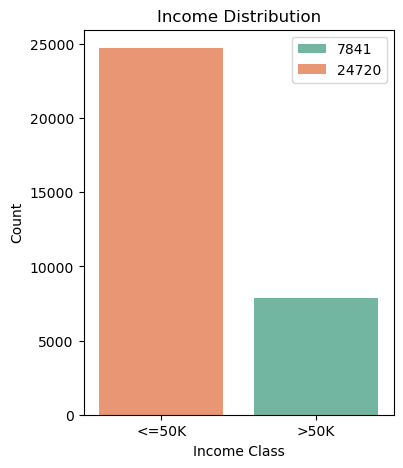

In [18]:
income_categories = ['<=50K', '>50K']
income_counts = adult_train['income'].value_counts()

fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(x=income_counts.index,
            y=income_counts.values,
            hue = income_counts.values,
            palette="Set2", 
            ax=ax)

ax.set_xlabel('Income Class')
ax.set_ylabel('Count')
ax.set_title('Income Distribution')

plt.show()

In [19]:
banner("*", 72, "Income Class Distribution")
class_distribution = adult_train["income"].value_counts(normalize=True) * 100
print(class_distribution)

************************************************************************
                       Income Class Distribution                        
************************************************************************
income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


These are preliminary results, and we will have to check them after finishing cleaning the features. 

We can see that about `75.9%` of the data belongs to the `<=50K` class, while only `24.1%` belongs to the `>50K` class. This is quite a significant difference, indicating an imbalance. We will keep this in mind so far. 

## Feature Exploration

### Categorical Variables

When exploring the features, I typically start with the categorical variables, as they often present the most complexity and challenges in data preprocessing. Categorical variables require special attention because they often contain unique values, missing data, or inconsistencies that can impact the model’s performance. By addressing these early, we can streamline the preprocessing steps and reduce potential issues later on. 

Let us start by check the dtypes we have in our data. 

In [20]:
print(adult_train.dtypes.unique())

[dtype('int64') dtype('O')]


This shows that our dataset contains only **integer** variables and **string** variables, where the string variables are indicated by `dtype('O')`, which stands for object data type in Pandas.

Let’s start by isolating the string (object) variables using the `select_dtypes()` method.

In [21]:
# Extract Categorical Features
object_features = [
    col for col in adult_train.select_dtypes(include='object').columns.to_list() if col !='income'
]

print(object_features)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


We will primarily explore these features by examining their frequency distributions and unique values using the `value_counts()` and `unique()` methods.

#### The `workclass` Feature

In [22]:
adult_train['workclass'].value_counts()

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

In [23]:
print(adult_train['workclass'].unique())

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


Upon initial inspection, we observe the presence of a `?` symbol, commonly used to signify missing data points in categorical variables. Addressing these missing values is a crucial step in the preprocessing stage. Additionally, it is evident that many of the categorical values contain leading whitespaces, which should be removed to ensure data consistency.

Another point to note is the presence of rare categories within the feature, which may require special handling during the modeling process.

We can proceed inspecting feature by feature, however this is not effective, so we defined a function to inspect them all at once:

In [24]:
banner("*", 72, "Inspecting Categorical Features")

for feature in object_features:
    get_feature_value_counts(adult_train, feature)

print("*"*72)

************************************************************************
                    Inspecting Categorical Features                     
************************************************************************

Value counts for 'workclass':

               Count  count
0            Private  22696
1   Self-emp-not-inc   2541
2          Local-gov   2093
3                  ?   1836
4          State-gov   1298
5       Self-emp-inc   1116
6        Federal-gov    960
7        Without-pay     14
8       Never-worked      7

Value counts for 'education':

            Count  count
0         HS-grad  10501
1    Some-college   7291
2       Bachelors   5355
3         Masters   1723
4       Assoc-voc   1382
5            11th   1175
6      Assoc-acdm   1067
7            10th    933
8         7th-8th    646
9     Prof-school    576
10            9th    514
11           12th    433
12      Doctorate    413
13        5th-6th    333
14        1st-4th    168
15      Preschool     51

Value count

Let us find the features that have the ` ?` value:

In [25]:
# find the columns that have ` ?`
has_q_mark = adult_train.isin([' ?']).sum()
print(has_q_mark)

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


In [26]:
# extract the features with ` ?`
features_with_q_mark = adult_train.columns[(adult_train == ' ?').any()].to_list()
print(features_with_q_mark)

['workclass', 'occupation', 'native-country']


In [27]:
# Check the values for features_with_q_mark
for feature in features_with_q_mark:
    print(adult_train[feature].unique())

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


### Replacing `?` with `np.nan`

In [28]:
adult_train[features_with_q_mark] = adult_train[features_with_q_mark].replace(' ?', np.nan)

In [29]:
# Check for np.nan for confirmation
adult_train.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

We have identified that several features contain leading spaces, which need to be removed to ensure data consistency. This can be efficiently handled by using the `apply()` method to strip the unwanted spaces.

In [30]:
# Apply the strip() method
# Apply str.strip() only to the specified columns
adult_train[object_features] = adult_train[object_features].apply(lambda x: x.str.strip())

In [31]:
# confirm
for feature in features_with_q_mark:
    print(adult_train[feature].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
['United-States' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands']


### Numerical Features

Numerical features play a crucial role in building predictive models, especially in regression and classification tasks. These features typically consist of continuous values, such as age, income, or hours worked per week, and represent measurable quantities. Analyzing and preprocessing numerical data requires careful attention to their distribution, scale, and presence of outliers, as these factors can significantly influence the model’s performance.

In this section, we will:

- Explore the distribution of numerical features in the dataset.
- Identify and handle potential outliers.
- Check for skewness or any other irregularities in the data distribution.
- Perform necessary preprocessing steps, such as scaling or normalizing the data to ensure the features are on comparable scales for model training.

In [32]:
# Extract numerical features
num_features = adult_train.select_dtypes(include=['int', 'float']).columns.to_list()
print(num_features)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [33]:
# Explore the numerical features
adult_train[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


Typically, data entry people use values with all 9s in order to mark `NaN` values in numerical features. Based on that, two suspicious features are: **capital-gain** and **hourse-per-week** might contain missing values. The **capital-loss** also has a very large maximum value, which has to be exposed to investigation as well. 

#### The Capital-gain Feature
Let us sort the values of capital-gain feature to check whether `99999` is a valid value:

In [34]:
adult_train["capital-gain"].value_counts(dropna=False).head(10)

capital-gain
0        29849
15024      347
7688       284
7298       246
99999      159
5178        97
3103        97
4386        70
5013        69
8614        55
Name: count, dtype: int64

In [35]:
# let us find the nlargest values
adult_train["capital-gain"].drop_duplicates().nlargest(10)

1246     99999
6433     41310
106      34095
1764     27828
704      25236
1562     25124
3593     22040
534      20051
17609    18481
6416     15831
Name: capital-gain, dtype: int64

In [36]:
# let us find the nsmallest values
adult_train["capital-gain"].drop_duplicates().nsmallest(10)

1          0
4716     114
2592     401
436      594
2543     914
4109     991
271     1055
4288    1086
656     1111
5884    1151
Name: capital-gain, dtype: int64

The second largest values is way less than `99999`, so we can consider that this is a missing value. Let us replace that with `np.nan`

In [37]:
adult_train['capital-gain'] = adult_train['capital-gain'].replace({99999: np.nan})

In [38]:
adult_train['capital-gain'].isnull().sum()

159

### The hours-per-week
We follow the same steps for the previous feature.

In [39]:
# let us find the nlargest values
adult_train["hours-per-week"].drop_duplicates().nlargest(10).to_list()

[99, 98, 97, 96, 95, 94, 92, 91, 90, 89]

There are few values close to this value. Let investigate a little more:

In [40]:
# Get the unique hours per week values
unique_hours_per_week = pd.Series(adult_train['hours-per-week'].unique())

# Get the top 10 largest unique values
top_hours_per_week = unique_hours_per_week.nlargest(10)

# Get the value counts for hours per week
hours_per_week_counts = adult_train['hours-per-week'].value_counts()

#  Filter the value counts to keep only the largest values
largest_hours_per_week_counts = hours_per_week_counts.loc[hours_per_week_counts.index.isin(top_hours_per_week)]

print(largest_hours_per_week_counts)

hours-per-week
99    85
90    29
98    11
96     5
91     3
95     2
97     2
89     2
92     1
94     1
Name: count, dtype: int64


I find this value (99) unusually large, and it’s reasonable to consider it as potentially missing data. 

In [41]:
# Replace 99 with np.nan
adult_train['hours-per-week'] = adult_train['hours-per-week'].replace({99: np.nan})

### The capital-loss Feature

In [42]:
adult_train["capital-loss"].value_counts(dropna=False).head(10)

capital-loss
0       31042
1902      202
1977      168
1887      159
1848       51
1485       51
2415       49
1602       47
1740       42
1590       40
Name: count, dtype: int64

In [43]:
# let us find the nlargest values
adult_train["capital-loss"].drop_duplicates().nlargest(10)

8963     4356
20416    3900
11902    3770
12600    3683
5309     3004
5713     2824
25793    2754
8321     2603
5979     2559
2414     2547
Name: capital-loss, dtype: int64

In [44]:
#  Get the unique capital-loss values
unique_capital_loss = pd.Series(adult_train['capital-loss'].unique())

# Get the top 10 largest unique values
top_capital_loss = unique_capital_loss.nlargest(10)

#  Get the value counts for capital-loss
capital_loss_counts = adult_train['capital-loss'].value_counts()

# Filter the value counts to keep only the largest values
largest_capital_loss_counts = capital_loss_counts.loc[capital_loss_counts.index.isin(top_capital_loss)]

print(largest_capital_loss_counts)

capital-loss
2559    12
2824    10
2603     5
2547     4
4356     3
3770     2
3683     2
2754     2
3900     2
3004     2
Name: count, dtype: int64


### Check Duplicates in Data
Checking for duplicates in the data is essential, as their presence can introduce bias and distort the accuracy of the analysis.

In [45]:
# Calculate the number of duplicate rows
num_duplicates = adult_train.duplicated().sum()

# Calculate the percentage of duplicates
percentage_duplicates = (num_duplicates / len(adult_train)) * 100

print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")

Percentage of duplicate rows: 10.64%


In [46]:
# drop the duplicates 
print(f"The shape before droping duplicates: {adult_train.shape} ")

adult_train = adult_train.drop_duplicates()

print(f"The shape after droping duplicates: {adult_train.shape} ")

The shape before droping duplicates: (32561, 14) 
The shape after droping duplicates: (29096, 14) 


### Preprocessing

Once the data has been cleaned, the next step is to preprocess it, which includes handling missing values through imputation.

We’ll begin by examining the distribution of numerical features, starting with:

1. **The capital Gain**

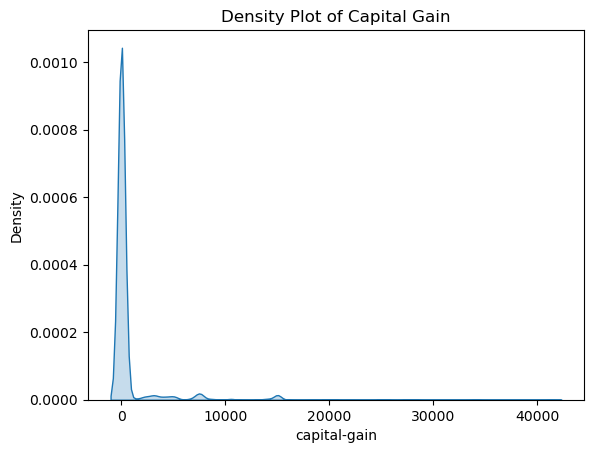

In [47]:
# Check the distribution
sns.kdeplot(adult_train['capital-gain'], fill=True)
plt.title('Density Plot of Capital Gain')
plt.show()

In [48]:
adult_train['capital-gain'].describe()

count    28938.000000
mean       658.352720
std       2690.727981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      41310.000000
Name: capital-gain, dtype: float64

We can see that the dominant value in this feature is zero, because the min, percentiles and median are zero. Let us plot that without that value. 

In [49]:
# Check the dominant value
np.mean(adult_train['capital-gain']==0)

0.9072724773164696

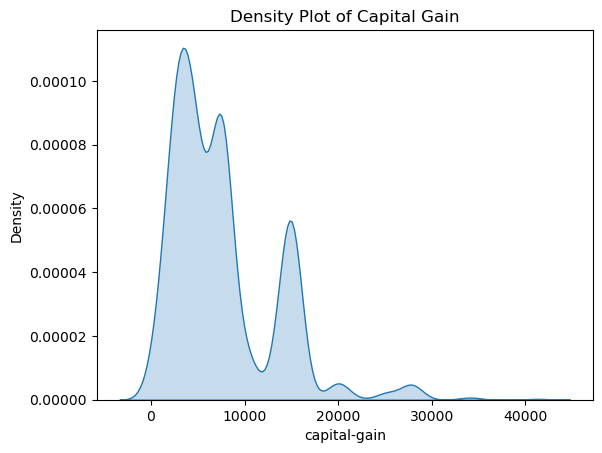

In [50]:
# Plotting the distribution without the dominant `zero` value
sns.kdeplot(adult_train[adult_train['capital-gain'] != 0]['capital-gain'], fill=True)
plt.title('Density Plot of Capital Gain')
plt.show()

In [51]:
# Checking the missing data points percentage
missing_percentage = adult_train['capital-gain'].isna().mean() * 100
print(f"Missing values: {missing_percentage:.2f}%")

Missing values: 0.54%


We can use the `zero` value to impute the missing data points

In [52]:
# Impute with the zero value
adult_train['capital-gain'] = adult_train['capital-gain'].fillna(value = 0)

2. **Hours Per Week Feature**

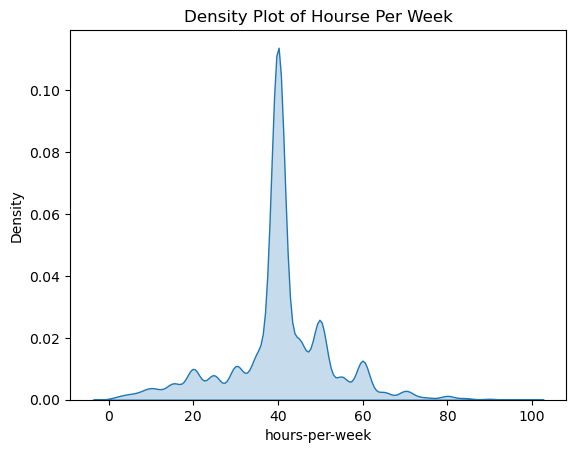

In [53]:
sns.kdeplot(adult_train['hours-per-week'], fill=True)
plt.title('Density Plot of Hourse Per Week')
plt.show()

In [54]:
adult_train['hours-per-week'].describe()

count    29011.000000
mean        40.466823
std         12.355435
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         98.000000
Name: hours-per-week, dtype: float64

We will use the mean imputation method based on the previous plot and statistics.

In [55]:
adult_train['hours-per-week'] = adult_train['hours-per-week'].fillna(value=adult_train['hours-per-week'].mean())

### Explore Numerical Features

### Numerical Feature Distributions

Let us explore the numerical features further. We defined a function to ease the process where we plot the histogram and the boxplot of each numerical feature.

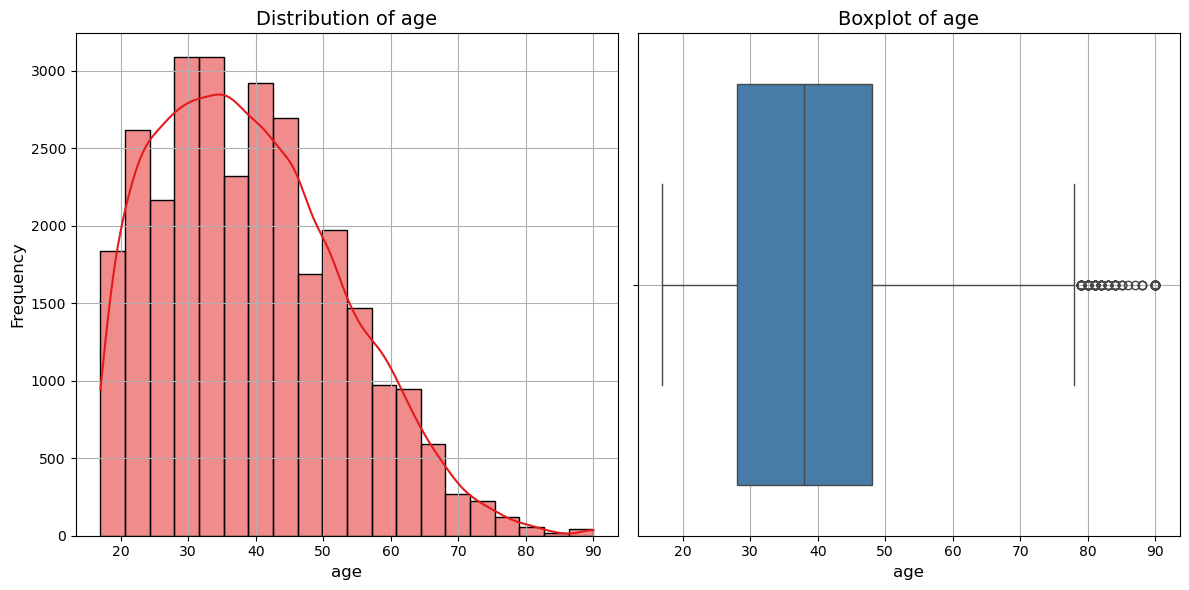

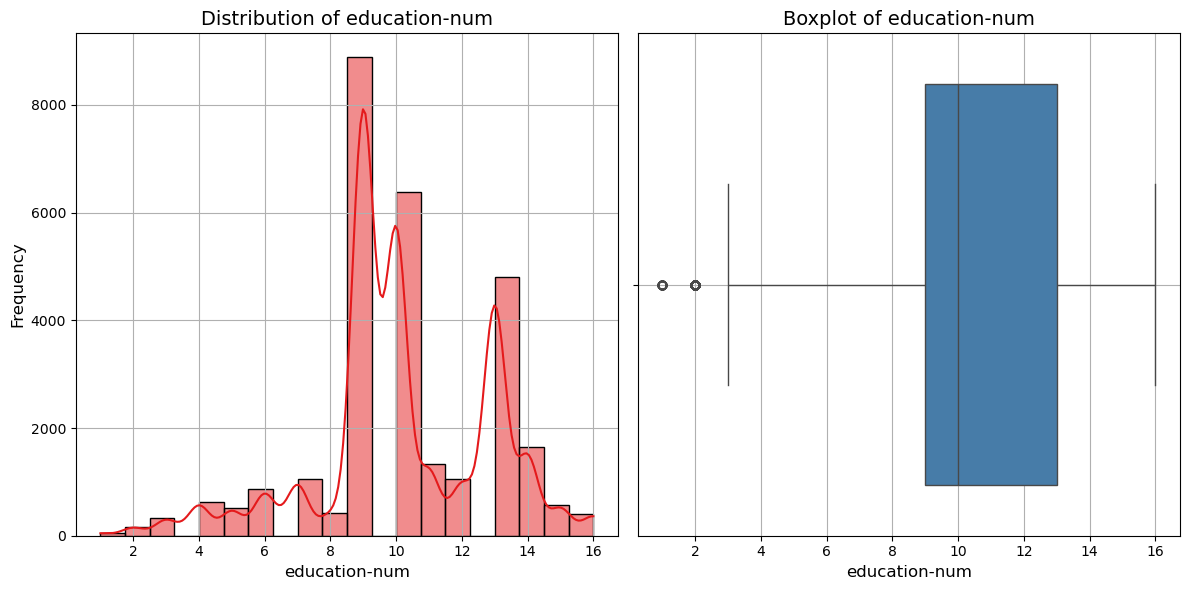

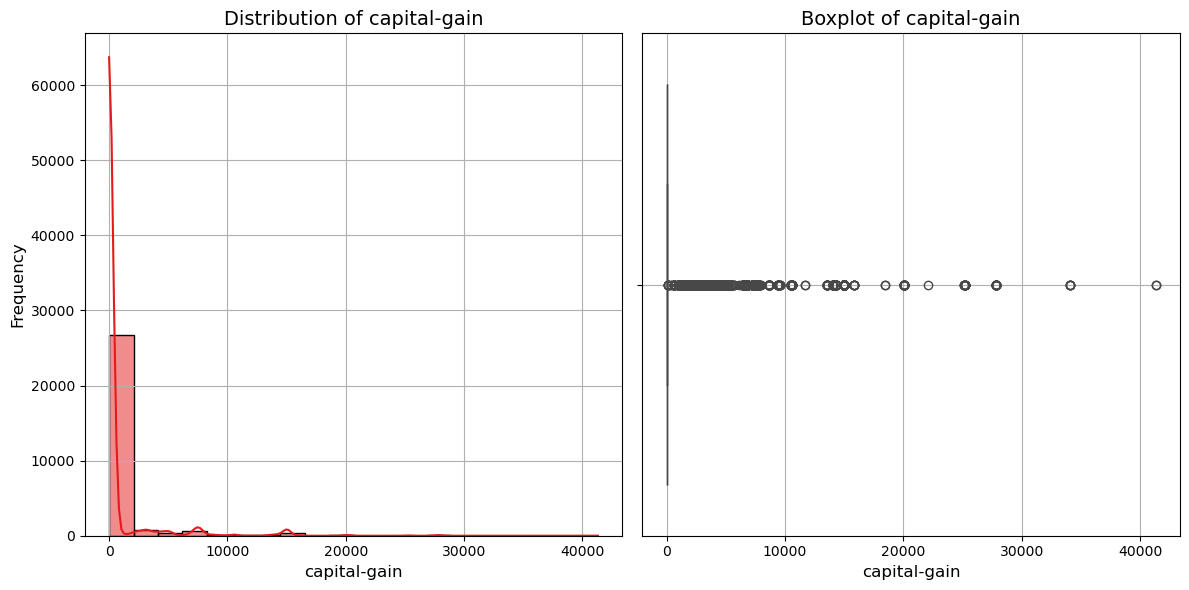

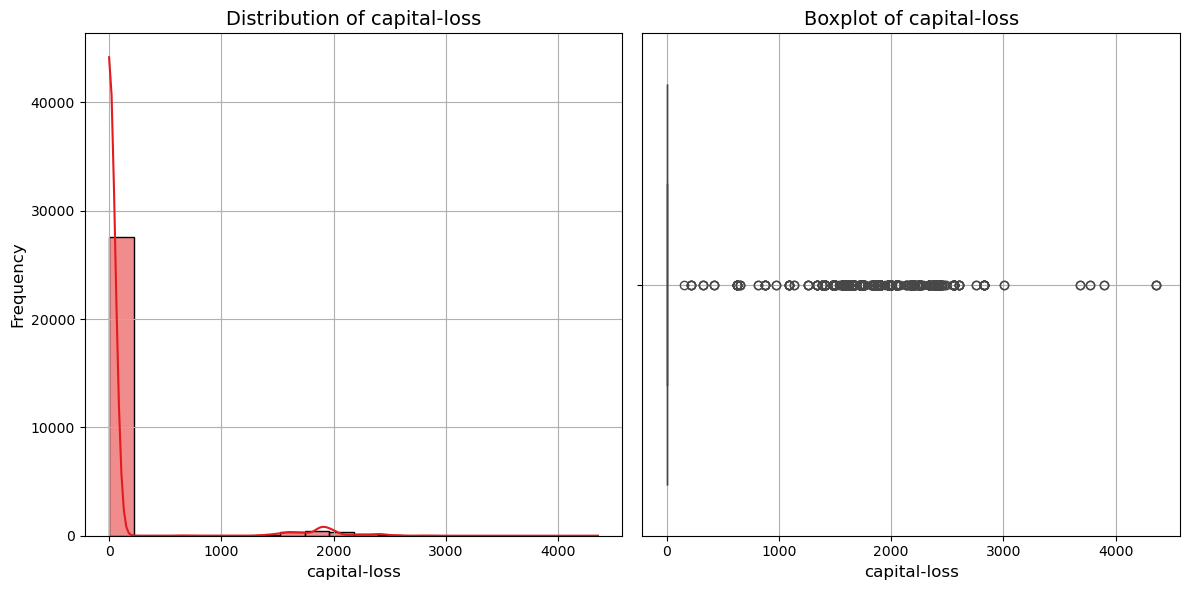

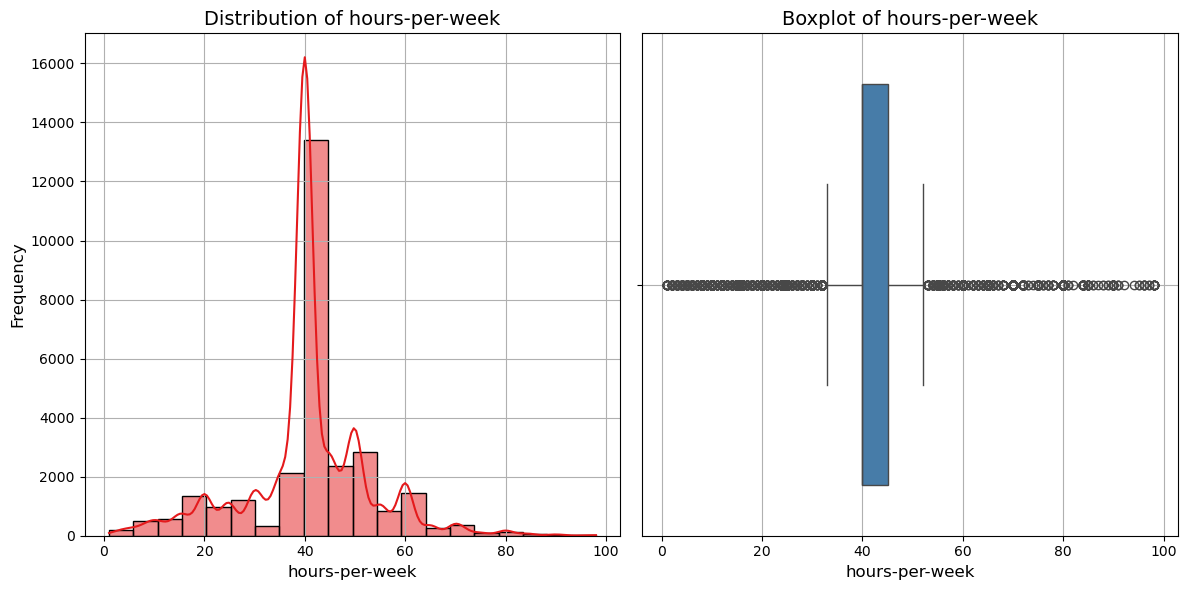

In [56]:
# Explore the numerical features
explore_numerical_features(adult_train, num_features)

Let us explore further

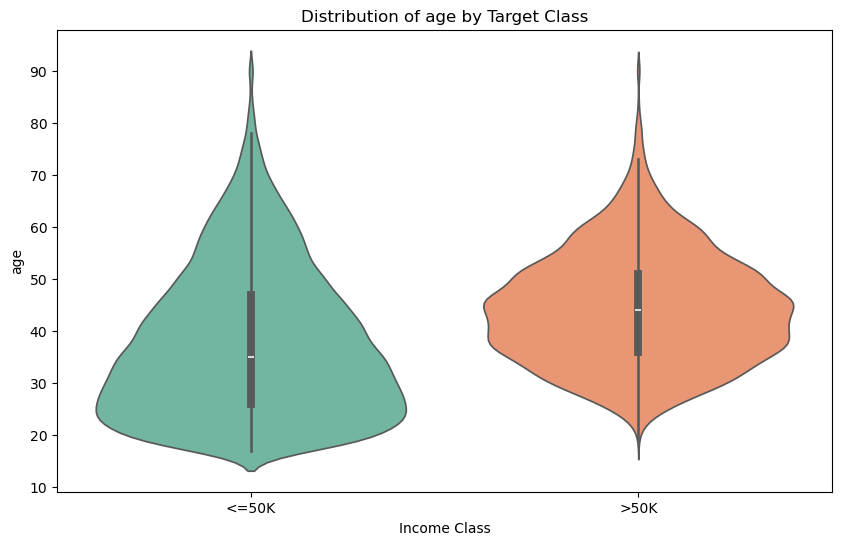

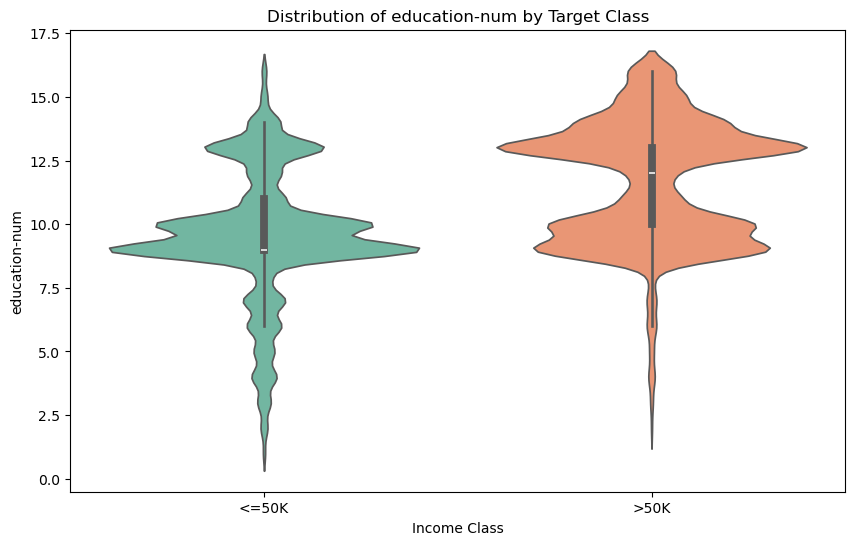

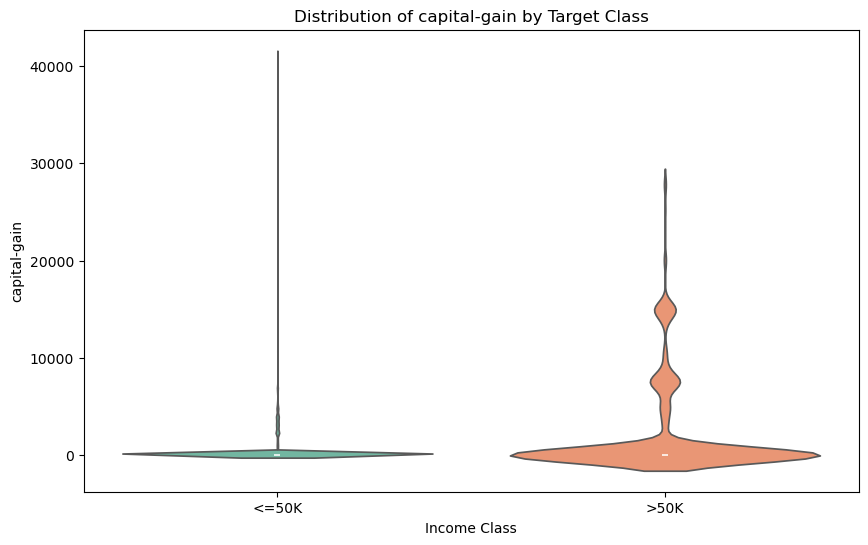

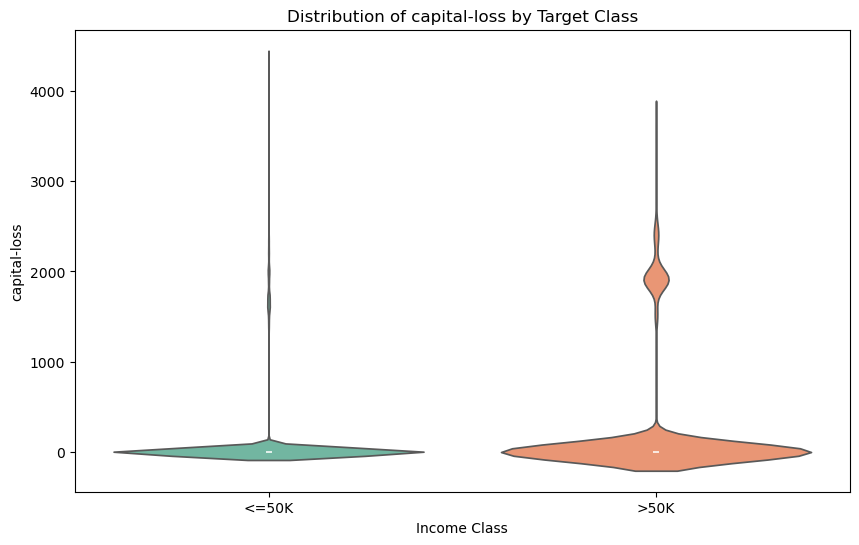

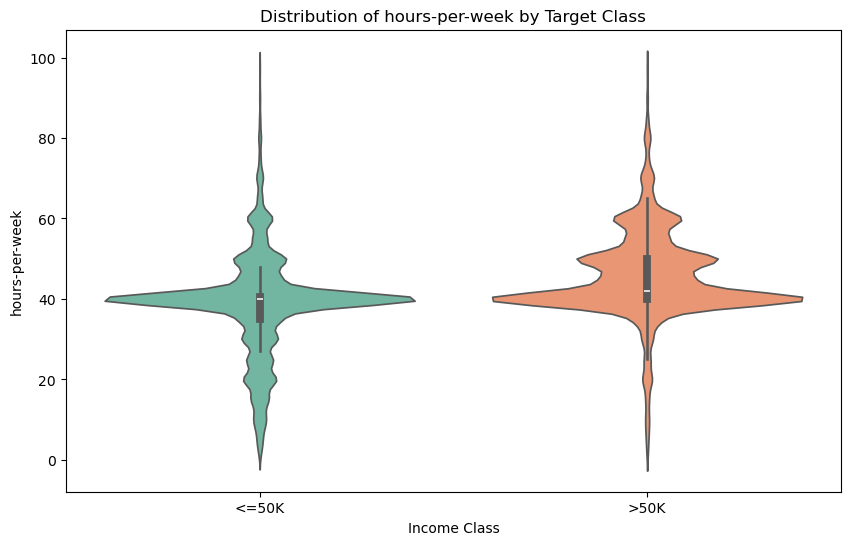

In [57]:
for col in num_features:
    plt.figure(figsize=(10, 6))
    
    # Create the violin plot
    sns.violinplot(x='income',
                   y=col,
                   hue = 'income',
                   legend = False,
                   data=adult_train,
                   palette="Set2")
    
    # Set plot title and labels
    plt.title(f'Distribution of {col} by Target Class')
    plt.xlabel('Income Class')
    plt.ylabel(col)
    
    plt.show()

### Correlation Analysis

                     age  education-num  capital-gain  capital-loss  \
age             1.000000       0.030144      0.110263      0.049570   
education-num   0.030144       1.000000      0.145539      0.080259   
capital-gain    0.110263       0.145539      1.000000     -0.055915   
capital-loss    0.049570       0.080259     -0.055915      1.000000   
hours-per-week  0.036796       0.143342      0.081495      0.052369   

                hours-per-week  
age                   0.036796  
education-num         0.143342  
capital-gain          0.081495  
capital-loss          0.052369  
hours-per-week        1.000000  


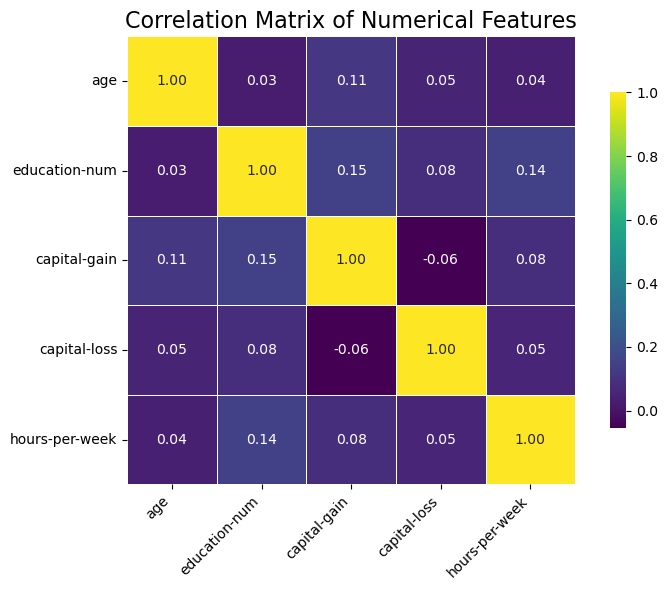

In [58]:
# Compute the correlation matrix for the numerical features
corr_matrix = adult_train._get_numeric_data().corr()
print(corr_matrix)
plt.figure(figsize=(8, 6))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", 
            linewidths=0.5, square=True, cbar_kws={"shrink": .75})

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Analyzing Numerical Features by Income Class

In this section, we will categorize each numerical feature according to the income class. This approach helps to provide a clearer understanding of how each feature behaves relative to income levels, allowing us to gain deeper insights into the relationships between these variables and the target outcome. By grouping data in this manner, we can better identify patterns, trends, and potential predictive power of the numerical features in relation to income classification.

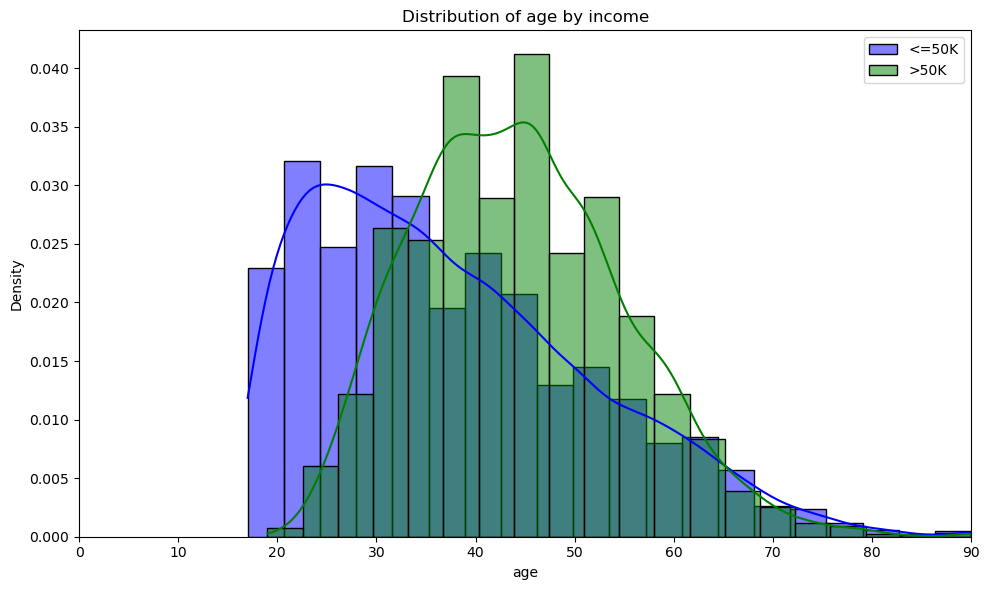

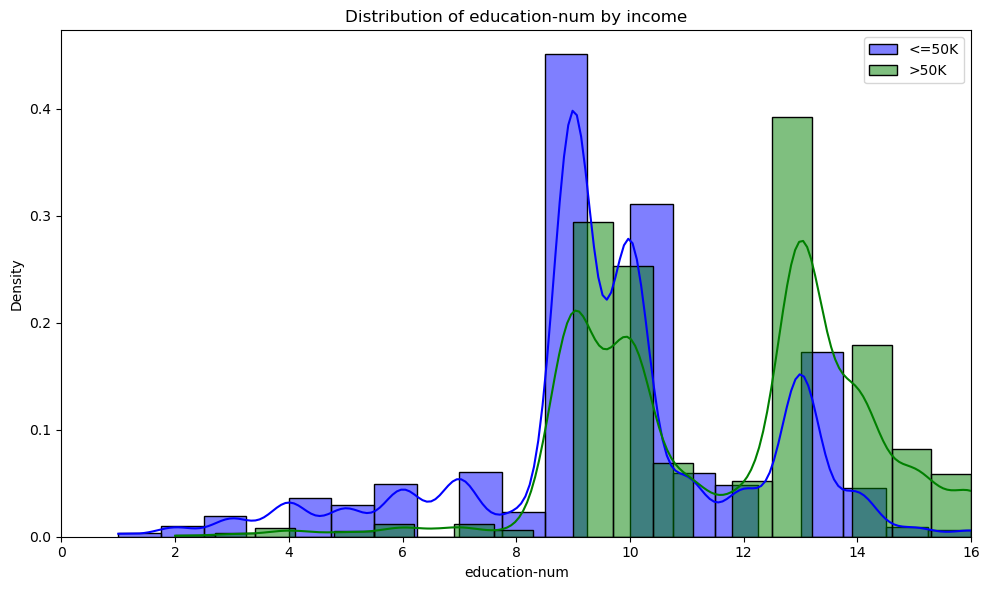

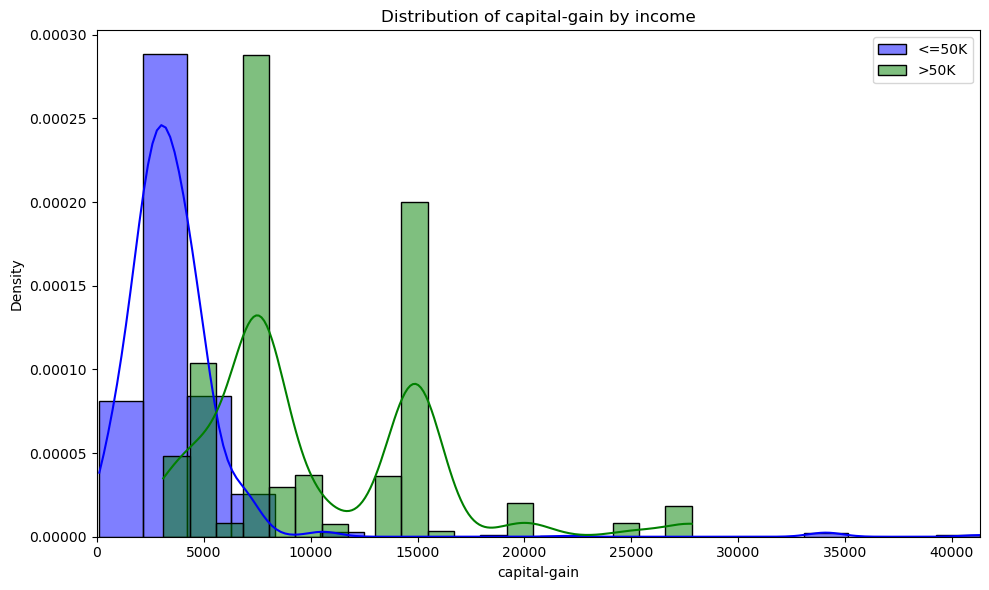

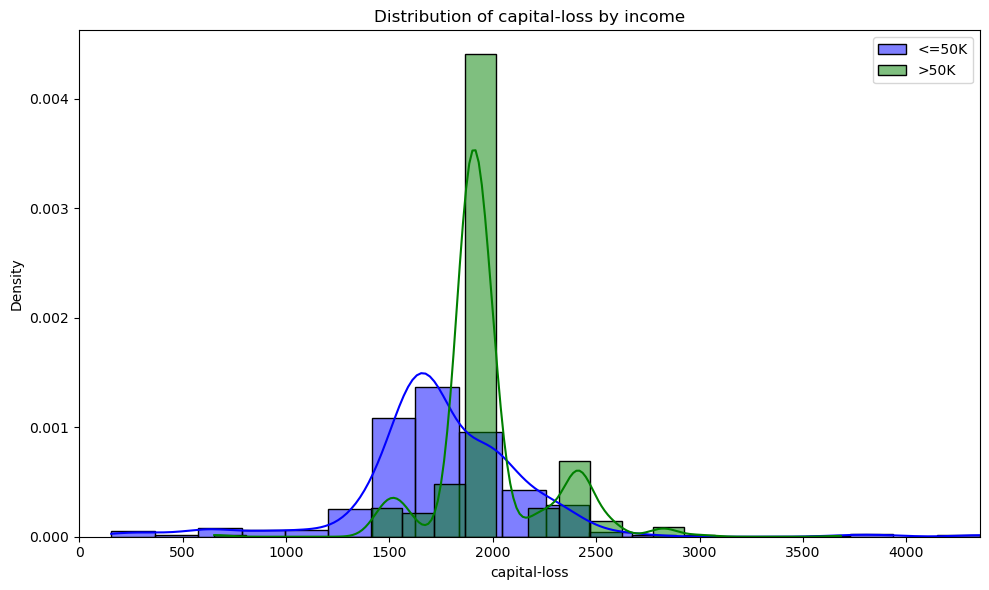

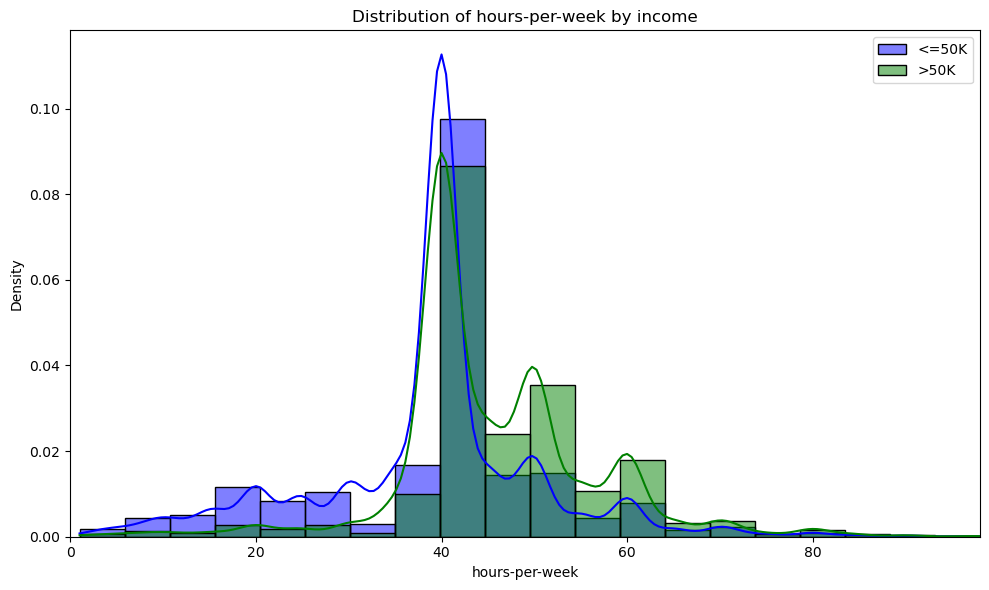

In [59]:
# Loop through the numeric columns and plot
for colname in adult_train._get_numeric_data().columns.to_list():
    plot_numeric_distribution(adult_train, target_column='income', colname=colname)

**Key Insights**: 

1. The **age** feature:
2. The **education-num** feature:
3. 

### Explore Categorical Features

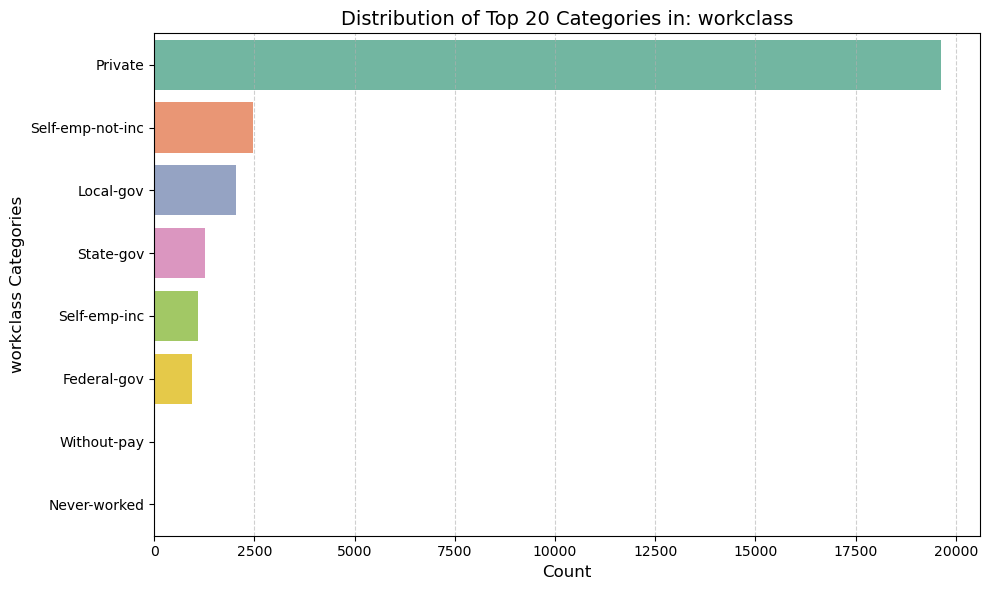

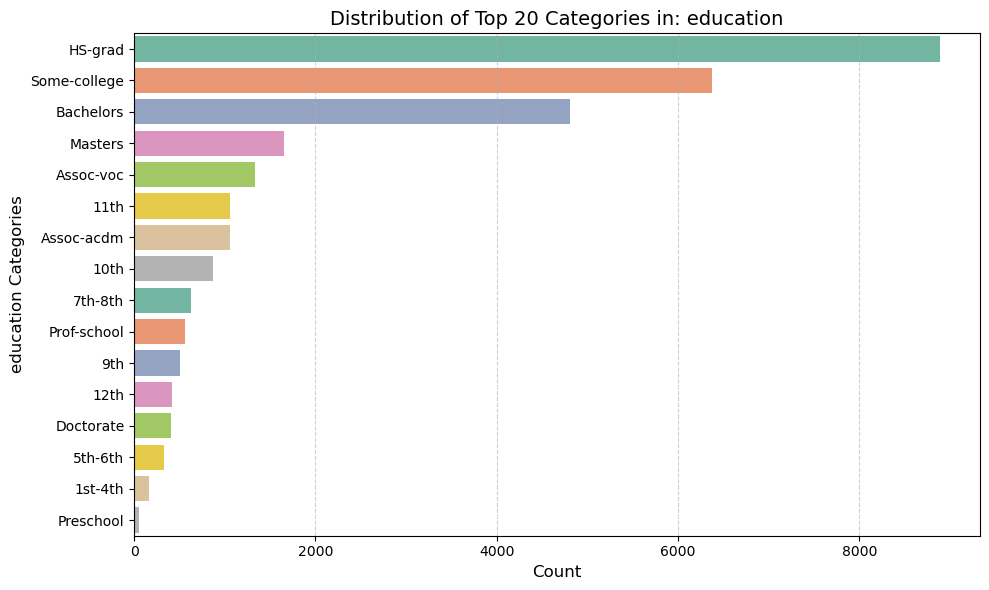

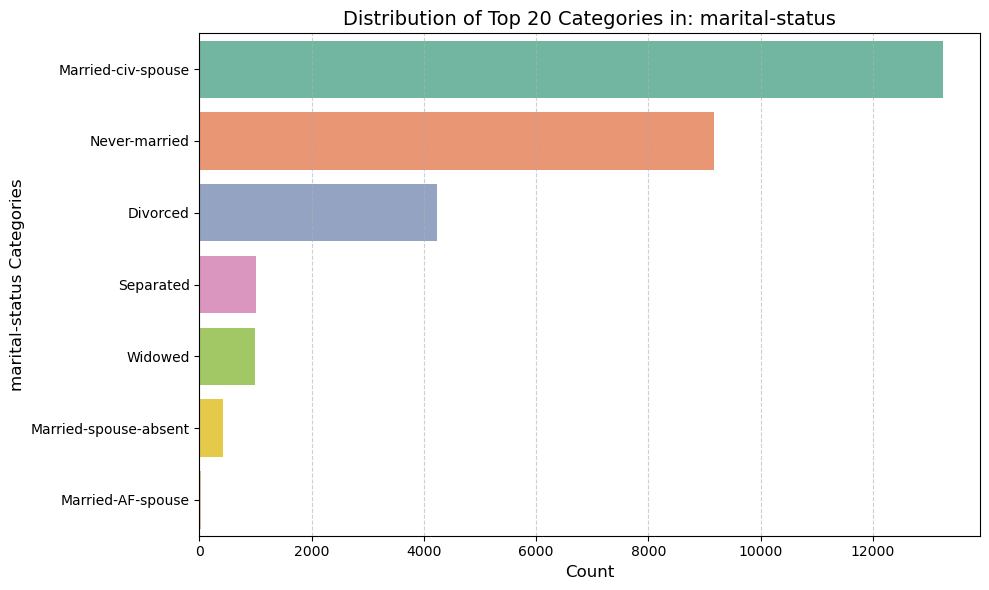

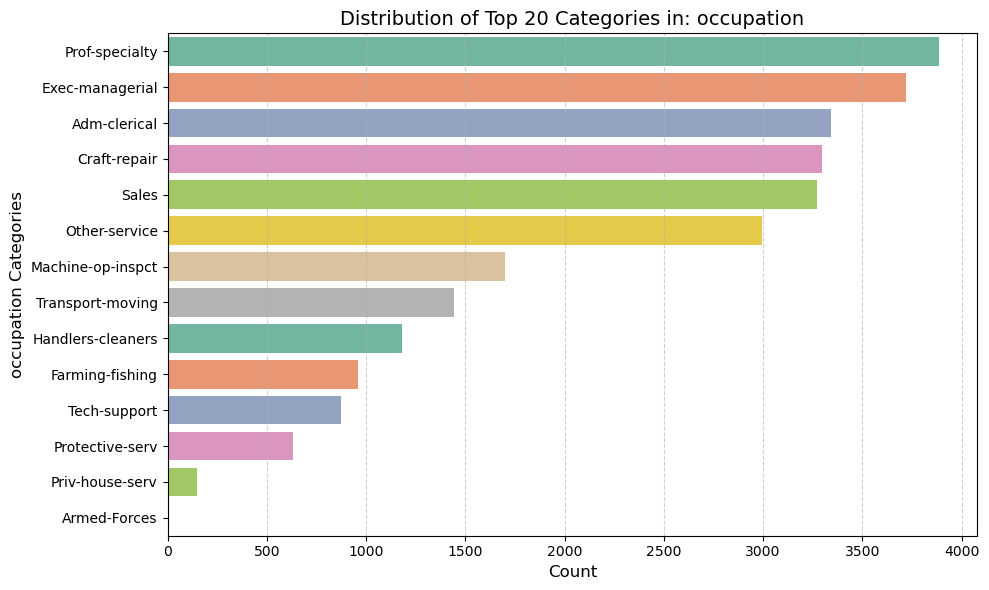

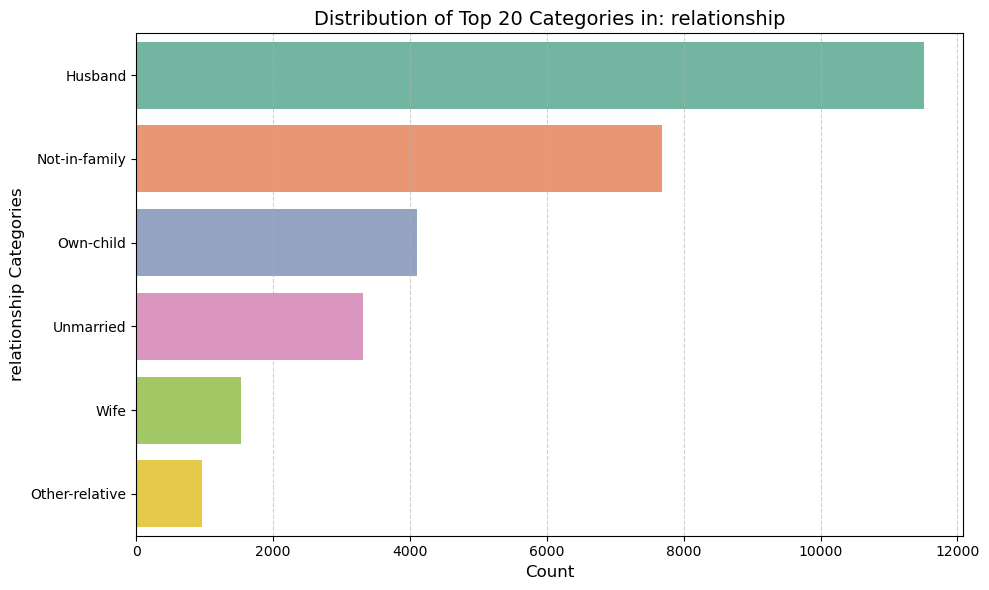

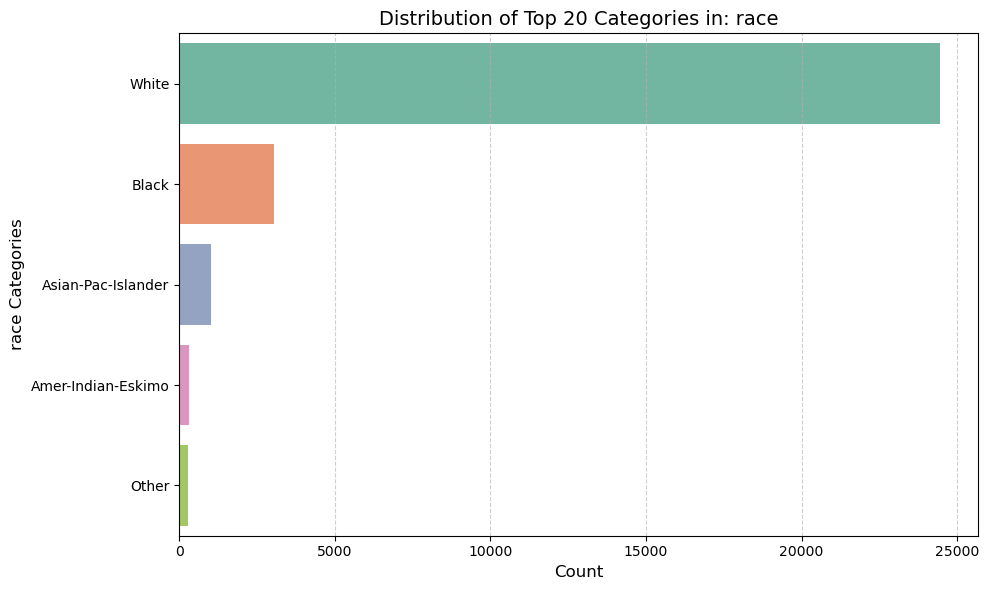

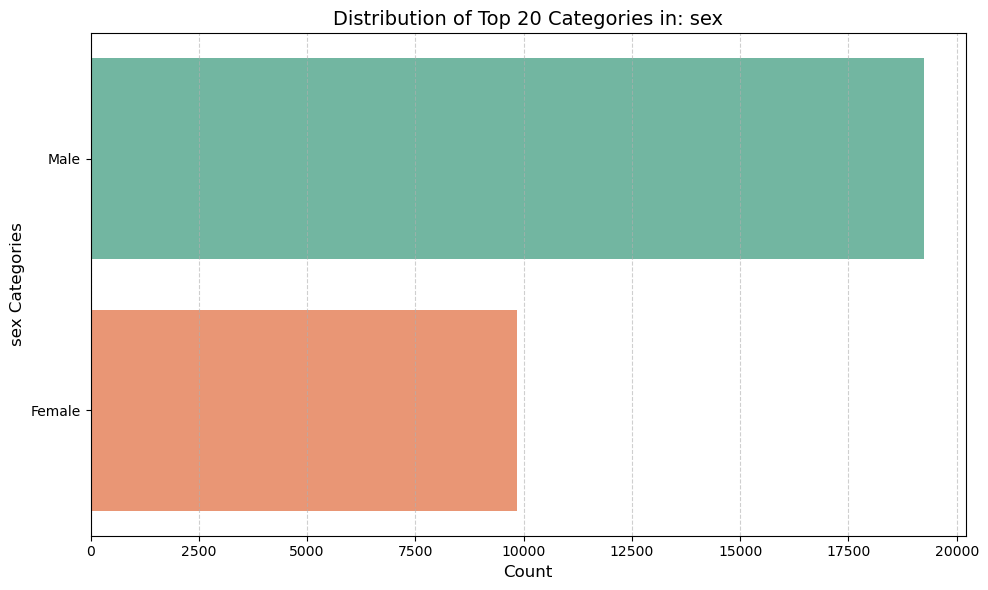

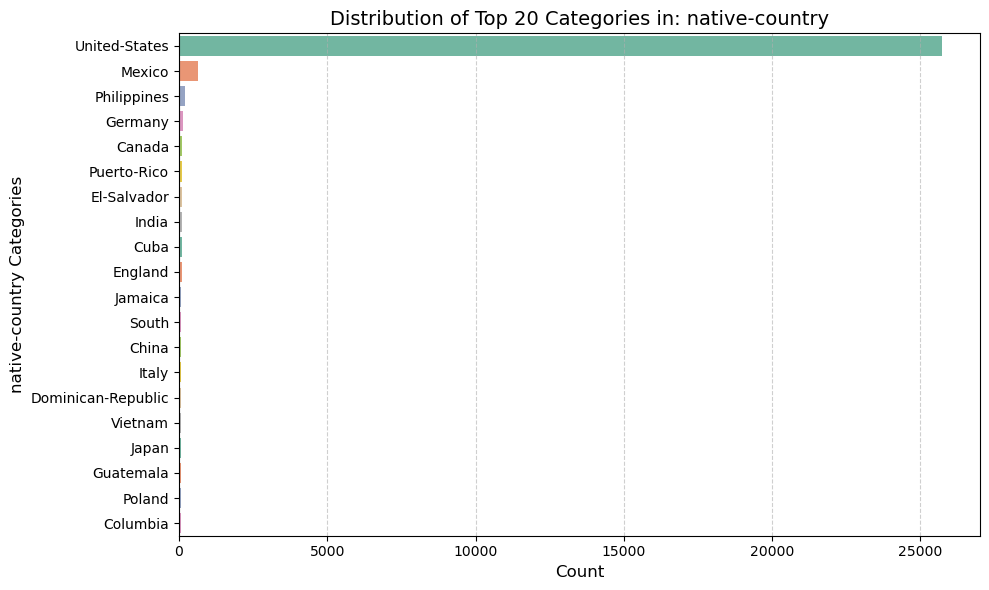

In [60]:
color_palette = 'Set2'
for colname in object_features:
    value_counts = adult_train[colname].value_counts().head(20)
    
    unique_count = len(value_counts)
    colors = sns.color_palette(color_palette, unique_count)  
    
    plt.figure(figsize=(10, 6)) 
    plt.title(f'Distribution of Top {20} Categories in: {colname}', fontsize=14)
    
    sns.barplot(
        x=value_counts.values, 
                    y=value_counts.index, 
                    hue=value_counts.index,  
                    palette=colors, 
                    dodge=False,  
                    legend=False
    )  
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(f'{colname} Categories', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)  
    plt.tight_layout()  
    plt.show()

### Categorical Features Categorized by Target Classes

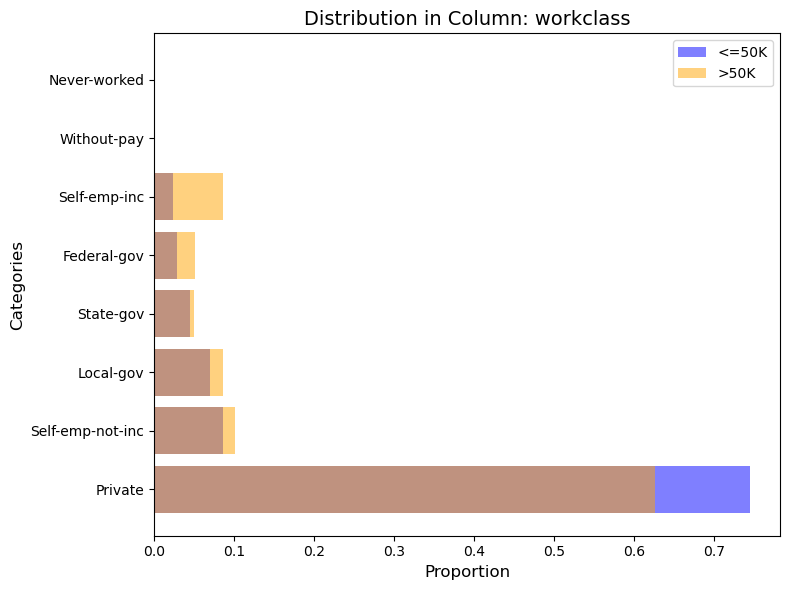

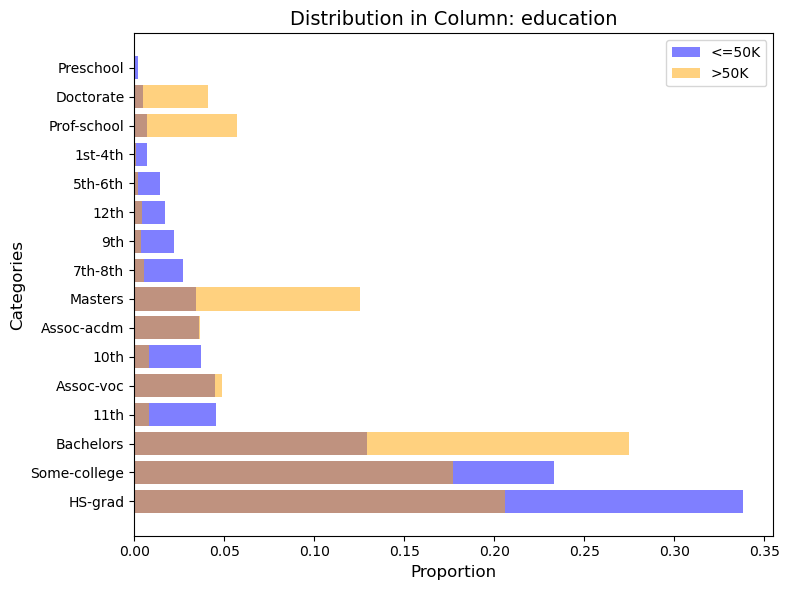

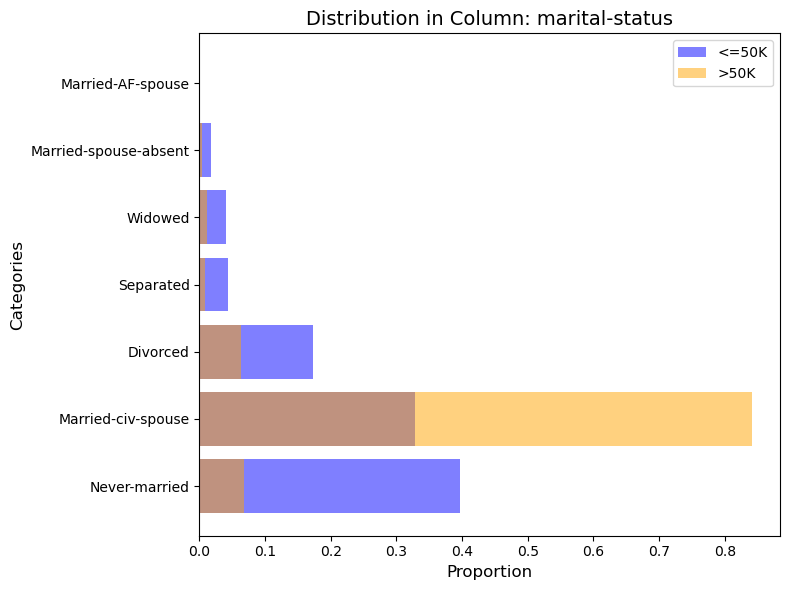

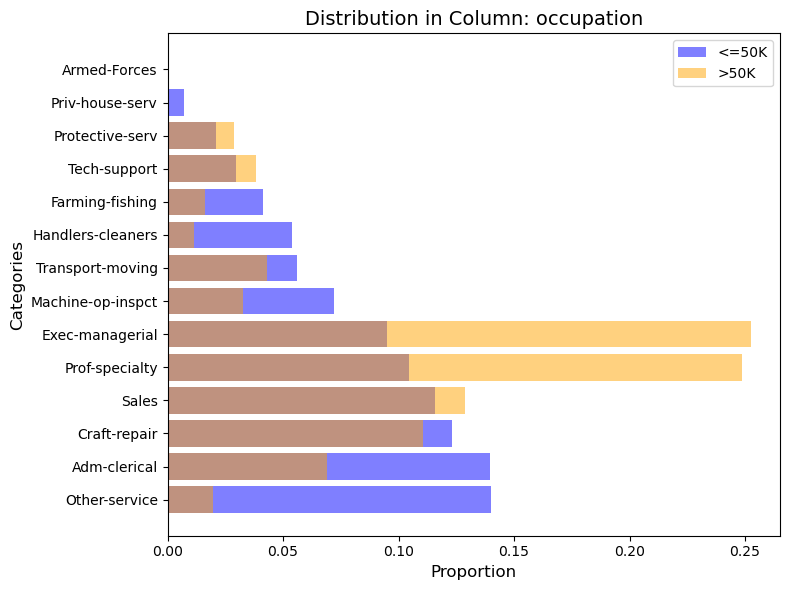

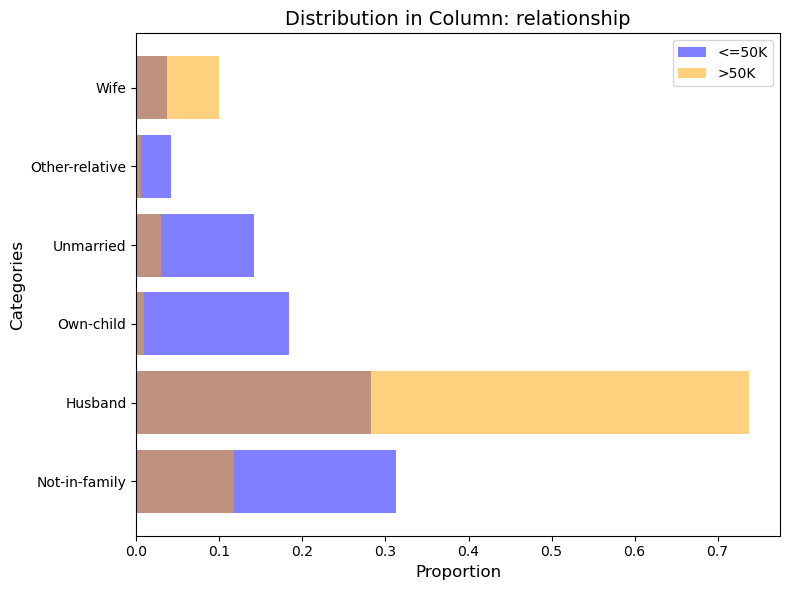

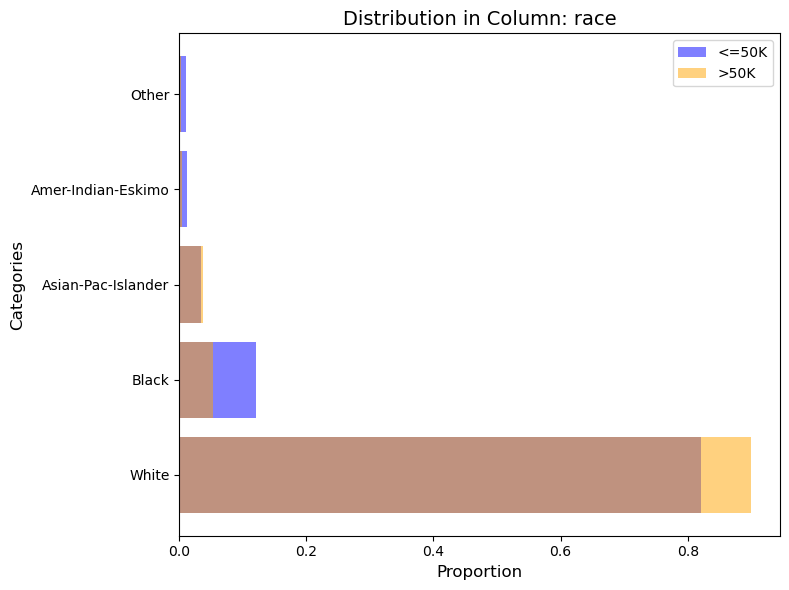

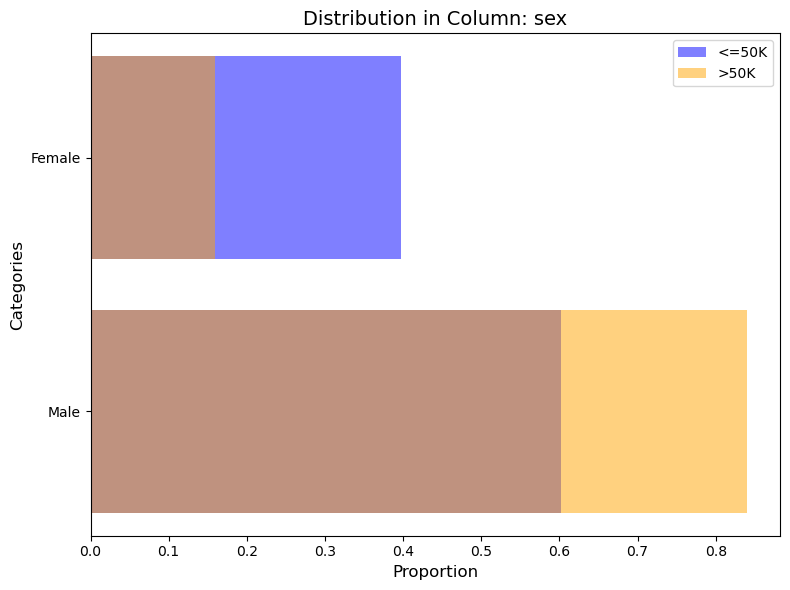

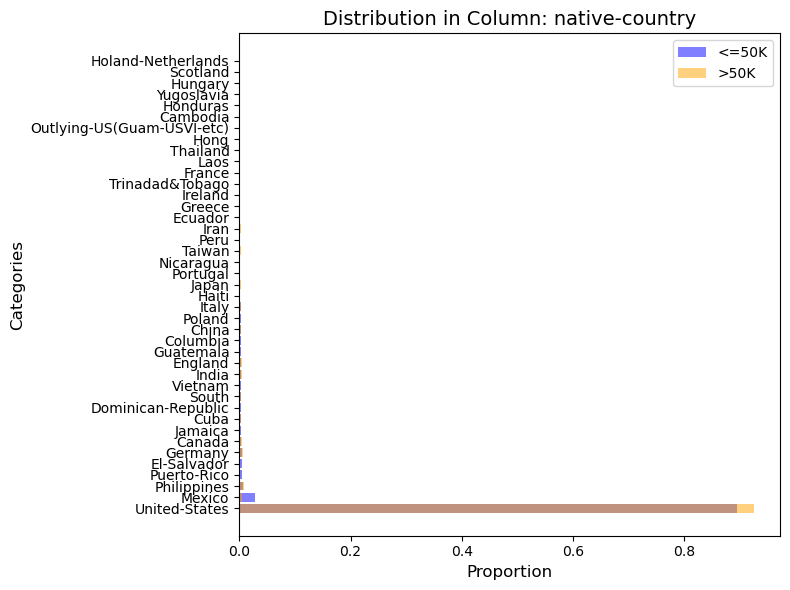

In [61]:
target_column = 'income'
compare_categorical_columns(adult_train, target_column, object_features)

### The Ambiguous Class Overlap

This situation refers to a situation in a machine learning project where different combinations of features (input data) lead to both possible outcomes or classes. This means that the model has difficulty making accurate predictions because the same set of features might belong to multiple classes, creating confusion.

For example, if we are trying to predict whether someone earns more or less than $50K, but for certain combinations of features like age, education, and occupation, people are found in both income categories, it becomes hard for the model to distinguish between them. This is called **Ambiguous Class Overlap**, where the boundaries between classes are not clear.

In [62]:
all_columns = adult_train.columns.tolist()
predictor_columns = [col for col in all_columns if col != target_column]

# Group the dataset by predictor columns and count the unique values for the 'income' column
# This helps to check for ambiguous class overlap where both income classes are present
column_frequency = (
    adult_train
    .groupby(predictor_columns, as_index=False)
    .agg({'income': 'nunique'})
)

# Filter for cases where both income classes (<=50K and >50K) are present
ambiguous_cases = column_frequency[column_frequency['income'] == 2]
num_ambiguous_cases = ambiguous_cases.shape[0]

print(f"Number of ambiguous cases with both income classes: {num_ambiguous_cases}")

Number of ambiguous cases with both income classes: 597


## Double Check Target Variable

In [63]:
banner("*", 72, "Income Class Distribution")
class_distribution = adult_train["income"].value_counts(normalize=True) * 100
print(class_distribution)

************************************************************************
                       Income Class Distribution                        
************************************************************************
income
<=50K    75.219962
>50K     24.780038
Name: proportion, dtype: float64


We will do feature engineering and scaling in the next notebook. It is a good time to save the data in an **interim** directory, as the data is semi-processed. 

In [64]:
adult_train.to_csv("data/interim/adult_train_semi_processed.csv", index=False)